In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
transform = transforms.ToTensor() # Will convert each image to a tensor

In [6]:
train_data = datasets.MNIST(root='./PYTORCH_NOTEBOOKS/Data',train=True,download=True,transform=transform)

In [7]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./PYTORCH_NOTEBOOKS/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [8]:
test_data = datasets.MNIST(root='./PYTORCH_NOTEBOOKS/Data',train=False,download=True,transform=transform)
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./PYTORCH_NOTEBOOKS/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [10]:
print(train_data[0])  # contains the array for images and the label (answer)
print(type(train_data[0]))

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [11]:
image,label = train_data[0]

print(image.shape)

torch.Size([1, 28, 28])


In [12]:
print(label)

5


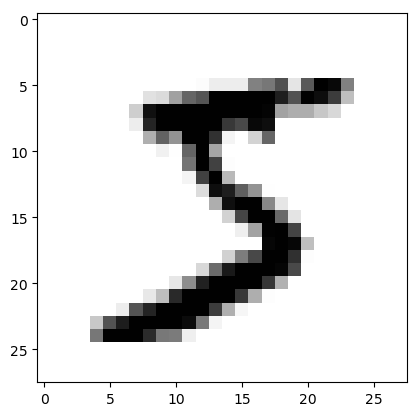

In [13]:
plt.imshow(image.reshape((28,28)),cmap="gist_yarg")   # Matplot default color mapping --> virdis

In [14]:
# Loading batches from the training data
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=100,shuffle=True)  # some datasets may be sorted, which can lead to training the network one category at a time. Shuffling allows for a general dataset
test_loader = DataLoader(test_data,batch_size=500,shuffle=False)

In [15]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [16]:
# Break out of the for loop right after the first iteration
for images, labels in train_loader:
    break

In [17]:
images.shape

torch.Size([100, 1, 28, 28])

In [18]:
labels.shape

torch.Size([100])

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


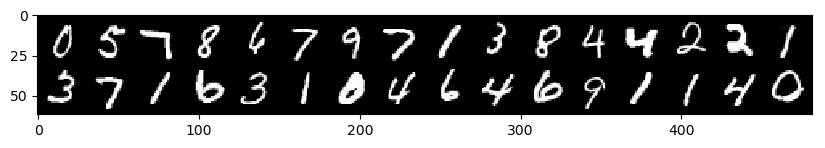

In [19]:
print('Labels: ',labels[:12].numpy())

im = make_grid(images[:32],nrow=16)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))  # Transpose is needed for plt.imshow to understand the image , go from CWH, WC (W-Width)(H-Height)(C-Color)

In [20]:
class MultilayerPerceptron(nn.Module):

    def __init__(self,in_sz=784,out_sz=10,layers=[120,84]):
        super().__init__()

        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)

    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1)  # multi class, classification




In [21]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
for param in model.parameters():
    print(param.numel())


94080
120
10080
84
840
10


In [23]:
# ANN has 105,214 parameters

In [24]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [25]:
# need to flatten out the images, from [100,1,28,28] to [100,784]
images.view(100,-1).shape

torch.Size([100, 784])

In [28]:
# Training of the model
import time
start_time = time.time()

epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(epochs):
    trn_corr = 0
    test_corr = 0

    for b,(X_train,y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if b%200 == 0:
            acc = trn_corr.item()*100 / (100*b)
            print(f'Epoch {i} Batch:{b} Loss: {loss.item()} Accuracy:{acc}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500,-1))

            predicted = torch.max(y_val.data,1)[1]
            test_corr += (predicted==y_test).sum()
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

total_time = time.time() - start_time
print(f"Duration: {total_time/60} minutes")

Epoch 0 Batch:200 Loss: 0.15956082940101624 Accuracy:93.955
Epoch 0 Batch:400 Loss: 0.1115182563662529 Accuracy:94.275
Epoch 0 Batch:600 Loss: 0.040039725601673126 Accuracy:94.74166666666666
Epoch 1 Batch:200 Loss: 0.12533552944660187 Accuracy:96.32
Epoch 1 Batch:400 Loss: 0.05490127205848694 Accuracy:96.3875
Epoch 1 Batch:600 Loss: 0.0218771081417799 Accuracy:96.455
Epoch 2 Batch:200 Loss: 0.02957853302359581 Accuracy:97.065
Epoch 2 Batch:400 Loss: 0.06167905032634735 Accuracy:97.2125
Epoch 2 Batch:600 Loss: 0.031061114743351936 Accuracy:97.21666666666667
Epoch 3 Batch:200 Loss: 0.10370619595050812 Accuracy:97.865
Epoch 3 Batch:400 Loss: 0.11849561333656311 Accuracy:97.8975
Epoch 3 Batch:600 Loss: 0.06125378608703613 Accuracy:97.87666666666667
Epoch 4 Batch:200 Loss: 0.030995965003967285 Accuracy:98.31
Epoch 4 Batch:400 Loss: 0.08699697256088257 Accuracy:98.3275
Epoch 4 Batch:600 Loss: 0.06089784577488899 Accuracy:98.245
Epoch 5 Batch:200 Loss: 0.027176348492503166 Accuracy:98.705
Epo

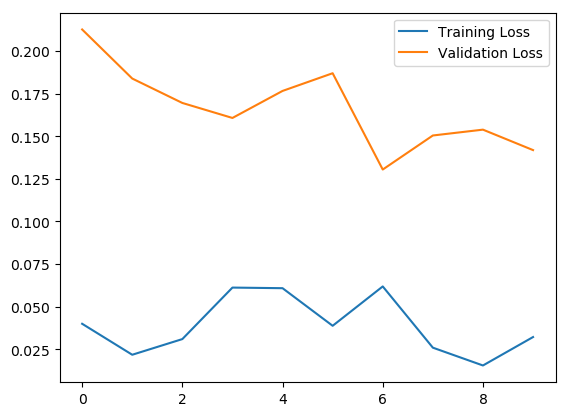

In [30]:
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label='Validation Loss')
plt.legend()

In [34]:
train_acc = [t/600 for t in train_correct]
print(train_acc)

[tensor(94), tensor(96), tensor(97), tensor(97), tensor(98), tensor(98), tensor(98), tensor(98), tensor(99), tensor(99)]


In [35]:
test_acc = [t/100 for t in test_correct]
print(test_acc)

[tensor(96), tensor(96), tensor(97), tensor(97), tensor(97), tensor(97), tensor(97), tensor(97), tensor(97), tensor(97)]


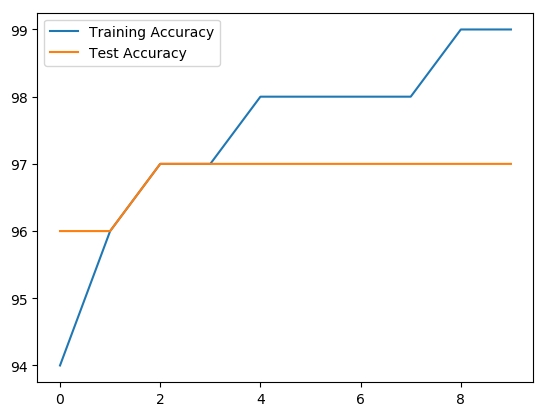

In [36]:
plt.plot(train_acc,label='Training Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.legend()

In [37]:
# New Unseen Data

test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [39]:
with torch.no_grad():
    correct = 0
    
    for X_test,y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted==y_test).sum()

In [41]:
print(100*correct.item()/len(test_data))

97.73


In [42]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 970,    0,    3,    1,    1,    2,    3,    1,    6,    2],
       [   0, 1124,    1,    0,    0,    0,    3,    6,    0,    2],
       [   2,    4, 1013,   10,    0,    0,    2,   12,    3,    1],
       [   0,    1,    1,  981,    1,    5,    1,    2,    3,    2],
       [   0,    0,    0,    0,  949,    1,    1,    3,    1,    2],
       [   0,    1,    0,    6,    0,  874,    3,    0,    8,   11],
       [   4,    2,    3,    2,    8,    7,  945,    0,    3,    1],
       [   0,    0,    3,    3,    2,    0,    0,  995,    4,    5],
       [   3,    3,    7,    5,    1,    2,    0,    1,  943,    4],
       [   1,    0,    1,    2,   20,    1,    0,    8,    3,  979]],
      dtype=int64)

In [44]:
torch.save(model.state_dict(), 'MNIST_Model.pt')